# SCOREO / SIMULACION

A partir de esta versión de la notebook de simulacion (v3) el foco de la muestra es únicamente de "alta presencia". Se compone de los Grupos 1, 2, 3 y 4, los cuales son los grupos que contienen los marca-modelo con suficiente muestra como para cotizarlo mediante el modelo. Los autos que no entren en esta categoría los cotizaremos mediante reglas duras o pasandolos directamente al equipo de Pricing

## Librerías y configuraciones de la notebook

In [1]:
##### Librerías y modulos #######
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from pandas.io import gbq
from datetime import datetime
import warnings
import openpyxl
import random
import os,json
import sys
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()),'src/'))
from funcs_cotizador import *

In [2]:
####### Configuraciones de la notebook (a gusto del usuario) ##########
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# warnings
warnings.filterwarnings("ignore")

In [3]:
#### Parametros de la notebook ####
path_save = '../datos/'
path_model = '../model/'

In [4]:
####### requierments ###########
#!pip install pandas-gbq

In [5]:
# Importar tabla OOT de Big Query
df_scoreo_oot = gbq.read_gbq("SELECT * FROM `data-team-k.pricing_data.match_meli_ok` WHERE date > '2022-04-01' ", project_id="data-team-k")

In [6]:
# checkpoint upload
#df_scoreo_oot.to_csv('{}df_score_oot_al_03_01'.format(path_save))

In [7]:
# checkpoint upload
#df_scoreo_oot = pd.read_csv('{}df_score_oot_al_03_01'.format(path_save))

In [8]:
# chequeo
print(len(df_scoreo_oot))
print(df_scoreo_oot.date.min(), df_scoreo_oot.date.max())

1490133
2022-03-02 2022-03-16


## *Seteo de parametros de la notebook*

In [9]:
# Semilla para el .sample()
seed = random.randint(10,500)

## 1) Pre procesing

In [10]:
# primer tratamiento (incluye todo menos el tratamiento de outliers por contexto)
df_scoreo_oot = data_cleaning_valset(df_scoreo_oot)

Hey! 1363757 were removed due to duplicate values
Hey! 1005 were removed due those 11111 or 9999 strange values
Hey! 72445 were removed due to 0km or concesioarias
Hey! 3525 were removed due to match scores under 50%
Hey! 0 were removed due to last 15d filter
Hey! 478 were removed due to outliers globales
Hey! 3281 were removed due to categories in which we are not interested in score


In [11]:
df_scoreo_oot.shape

(45642, 12)

In [12]:
# segundo tratamiento (incluye unicamente el tratamiento de outliers por contexto)
df_scoreo_oot = data_processing_1(df_scoreo_oot,path_save)

Hey! 4046 were removed from df due to outliers under context


## 2) Chequeo de nulls

In [13]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a']

In [14]:
# chequeamos que no haya nulls
# debido a que no hay ninguna imputacion de nulos en las funciones de procesamiento, si aparecen nulos aca el predict va a romper
# Es por eso que si aparecen, los dropeamos en la proxima celda
df_scoreo_oot.isnull().sum()

runtime           0
car_id            0
car_year          0
car_kms           0
match_marca_a     0
match_modelo_a    0
match_v1_a        0
Subseg_a          0
Seg_a             0
price_meli_ok     0
car_location_1    3
match_v1_c        0
dtype: int64

In [15]:
# Eliminamos los registros con nulos
for col in model_features:
    df_scoreo_oot_final = df_scoreo_oot[~df_scoreo_oot[col].isnull()]

In [16]:
df_scoreo_oot_final.shape

(41596, 12)

## 3) Seleccion muestra final (50 casos)

In [17]:
# Seleccion final de la muestra de 50 registros
df_oot_final_sample = df_scoreo_oot_final.sample(n=50, random_state=seed) 
df_oot_final_sample

,runtime,car_id,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,car_location_1,match_v1_c
448845,2022-03-16 15:00:57,1127166628,2015.0000,200000.0000,CHEVROLET,Corsa Classic,Wagon 1.4/1.6 N Life/Base,Gama Pequenos Hatchback,Gama Pequenos,890000.0000,Capital Federal,CLASSIC 1.4
1438763,2022-03-15 22:00:29,1119562570,2020.0000,10000.0000,FIAT,Cronos,1.8 AT Precision Pack Premium (130cv),Gama Pequenos Sedan,Gama Pequenos,3100000.0000,Bs.As. Costa Atlántica,PRECISION 1.8 MT
1484239,2022-03-15 20:00:32,1122807880,2015.0000,97000.0000,FIAT,Grand Siena,Attractive 1.4 MT,Gama Pequenos Sedan,Gama Pequenos,1750000.0000,Capital Federal,1.4
45283,2022-03-16 21:00:32,1120425933,2011.0000,113000.0000,VOLKSWAGEN,Vento,2.0 TDI Luxury DSG (140cv) (L11),Gama Medianos Sedan,Gama Medianos,2350000.0000,San Luis,2.0
655705,2022-03-06 11:00:46,1118599857,2013.0000,58000.0000,CITROEN,C4,5Ptas.- 1.6 16v X Pack Look (110cv),Gama Medianos Sedan,Gama Medianos,1648000.0000,Capital Federal,1.6
417880,2022-03-16 17:00:23,1125814831,2020.0000,12300.0000,VOLKSWAGEN,Virtus,1.6 Highline Tiptronic (110cv),Gama Pequenos Sedan,Gama Pequenos,4200000.0000,Bs.As. G.B.A. Norte,HIGHLINE 1.6 MSI 110CV AT
1649,2022-03-16 15:00:33,1123581051,2010.0000,125000.0000,CITROEN,C3,1.4i SX,Gama Pequenos Hatchback,Gama Pequenos,850000.0000,Buenos Aires Interior,1.1
502397,2022-03-16 04:00:22,1120643745,2013.0000,128000.0000,FORD,Fiesta,1.6 Trend (120cv) 4Ptas. (L10),Gama Pequenos Hatchback,Gama Pequenos,1550000.0000,Bs.As. G.B.A. Sur,1.1
739043,2022-03-08 01:00:26,1119681650,2012.0000,120000.0000,VOLKSWAGEN,CrossFox,1.6 Highline 5Ptas. (ABG ABS),Gama Pequenos Hatchback,Gama Pequenos,1500000.0000,San Luis,1.6
448993,2022-03-16 19:00:30,1124741136,2006.0000,224000.0000,FIAT,Weekend,1.8 Xtreme ABS,Gama Pequenos Sedan,Gama Pequenos,650000.0000,Bs.As. G.B.A. Oeste,ADVENTURE 1.8MPI V8


In [18]:
# nos quedamos solo con las features que usamos en el entrenamiento del modelo para hacer el predict del modelo
X_oot = df_oot_final_sample[model_features].copy()

## 4) Scoreo de la muestra final

In [19]:
# Paso 1: Levantamos el modelo ya entrenado en la notebook anterior
import pickle
with open('{}model_catboost_v3.pickle'.format(path_model), 'rb') as f:
    model = pickle.load(f)

In [20]:
# Paso 2: predict sobre la data nueva
pred = model.predict(X_oot)

In [21]:
type(pred)

numpy.ndarray

In [22]:
len(pred)

50

## 5) Armado del output final

In [23]:
# Precio promedio en MELI
grouped = df_scoreo_oot_final.groupby(['match_marca_a','match_modelo_a','match_v1_a','car_year'], as_index=False)['price_meli_ok'].mean()
grouped.rename(columns={'price_meli_ok':'precio_prom_meli'},inplace=True)
df_oot_final_sample = df_oot_final_sample.merge(grouped, how='inner', on=['match_marca_a','match_modelo_a','match_v1_a','car_year'])

In [24]:
df_oot_final_sample['precio_estimado'] = pred

In [25]:
df_oot_final_sample['precio_estimado'] = df_oot_final_sample['precio_estimado'].astype('int64')
df_oot_final_sample['precio_prom_meli'] = df_oot_final_sample['precio_prom_meli'].astype('int64')

In [26]:
from datetime import datetime
df_oot_final_sample['fecha_simulacion'] = datetime.today().strftime('%Y-%m-%d')

In [27]:
df_oot_final_sample.columns

Index(['runtime', 'car_id', 'car_year', 'car_kms', 'match_marca_a',
       'match_modelo_a', 'match_v1_a', 'Subseg_a', 'Seg_a', 'price_meli_ok',
       'car_location_1', 'match_v1_c', 'precio_prom_meli', 'precio_estimado',
       'fecha_simulacion'],
      dtype='object')

In [28]:
# Ordenamos las columnas de forma prolija
df_oot_final_sample = df_oot_final_sample[['car_id','match_marca_a','match_modelo_a','match_v1_a','match_v1_c'
                                                         ,'car_year','car_kms','Seg_a','Subseg_a','car_location_1'
                                                         ,'precio_estimado','precio_prom_meli','price_meli_ok','fecha_simulacion']]
df_oot_final_sample.rename(columns={'price_meli_ok':'precio_real'},inplace=True)
df_oot_final_sample['precio_real'] = df_oot_final_sample['precio_real'].astype('int64')

In [31]:
# chequeo
df_oot_final_sample.head()

,car_id,match_marca_a,match_modelo_a,match_v1_a,match_v1_c,car_year,car_kms,Seg_a,Subseg_a,car_location_1,precio_estimado,precio_prom_meli,precio_real,fecha_simulacion
0,1127166628,CHEVROLET,Corsa Classic,Wagon 1.4/1.6 N Life/Base,CLASSIC 1.4,2015.0000,200000.0000,Gama Pequenos,Gama Pequenos Hatchback,Capital Federal,1292192,890000,890000,2022-03-17
1,1119562570,FIAT,Cronos,1.8 AT Precision Pack Premium (130cv),PRECISION 1.8 MT,2020.0000,10000.0000,Gama Pequenos,Gama Pequenos Sedan,Bs.As. Costa Atlántica,2615889,2983333,3100000,2022-03-17
2,1122807880,FIAT,Grand Siena,Attractive 1.4 MT,1.4,2015.0000,97000.0000,Gama Pequenos,Gama Pequenos Sedan,Capital Federal,1388317,1562857,1750000,2022-03-17
3,1120425933,VOLKSWAGEN,Vento,2.0 TDI Luxury DSG (140cv) (L11),2.0,2011.0000,113000.0000,Gama Medianos,Gama Medianos Sedan,San Luis,2289120,2494744,2350000,2022-03-17
4,1118599857,CITROEN,C4,5Ptas.- 1.6 16v X Pack Look (110cv),1.6,2013.0000,58000.0000,Gama Medianos,Gama Medianos Sedan,Capital Federal,1568996,1464900,1648000,2022-03-17


In [32]:
# chequeo
df_oot_final_sample.precio_estimado.describe()

count        50.0000
mean    2017429.4200
std     1265176.2252
min      718501.0000
25%     1265236.2500
50%     1850856.0000
75%     2412663.7500
max     8484391.0000
Name: precio_estimado, dtype: float64

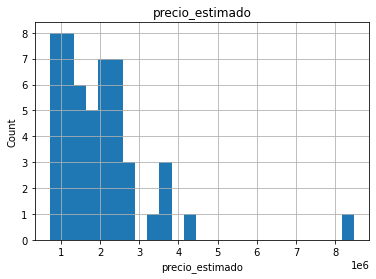

In [33]:
# chequeo
# Distribucion del target
df_oot_final_sample['precio_estimado'].hist(bins=25)
plt.xlabel('precio_estimado')
plt.ylabel("Count")
plt.title('precio_estimado')
plt.show()

In [34]:
df_oot_final_sample.shape

(50, 14)

**Chequeamos R2 y RMSE para la simulacion**

In [38]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(df_oot_final_sample.precio_real, df_oot_final_sample.precio_estimado)

Test set evaluation:
_____________________________________
MAE: 204007.06
MSE: 77091508014.54
RMSE: 277653.57554791187
R2 Square 0.9560933387695825
__________________________________


**Guardamos la simulacion**

In [37]:
# Guardamos el rdo final
current_date = datetime.today().strftime('%Y-%m-%d')
df_scoreo_oot_final_sample.to_excel(f'simulacion_{current_date}.xlsx')
# en esta última linea, poner el path que querramos para guardar el output